In [ ]:
pip install gtsam

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.8/21.8 MB 42.9 MB/s eta 0:00:00


In [ ]:
import gtsam
from gtsam import symbol
import numpy as np

# Symbols for variables
X0 = symbol('x', 0)  # Initial robot pose
X1 = symbol('x', 1)  # Next robot pose
L = symbol('l', 0)   # Landmark

# Create a factor graph
graph = gtsam.NonlinearFactorGraph()

# Noise models
pose_prior_noise = gtsam.noiseModel.Diagonal.Sigmas(np.array([0.1, 0.1, 0.1]))  # [x, y, theta]
odometry_noise = gtsam.noiseModel.Diagonal.Sigmas(np.array([0.2, 0.2, 0.1]))   # [x, y, theta]
measurement_noise = gtsam.noiseModel.Diagonal.Sigmas(np.array([0.1, 0.1]))     # [x, y]

# Add prior on the first pose
prior_pose = gtsam.Pose2(0, 0, 0)  # Starting at origin
graph.add(gtsam.PriorFactorPose2(X0, prior_pose, pose_prior_noise))

# Add odometry (robot motion) factors
odom1 = gtsam.Pose2(2.0, 0.0, 0.0)  # Move 2 meters forward
graph.add(gtsam.BetweenFactorPose2(X0, X1, odom1, odometry_noise))

# Add landmark measurement factors
landmark_measurement = gtsam.Point2(2.0, 2.0)  # Landmark is observed at (2, 2)
graph.add(gtsam.BearingRangeFactor2D(X1, L, gtsam.Rot2.fromAngle(0), 2.0, measurement_noise))

# Create initial estimate
initial_estimate = gtsam.Values()
initial_estimate.insert(X0, gtsam.Pose2(0.5, 0.0, 0.1))  # Initial guess for the first pose
initial_estimate.insert(X1, gtsam.Pose2(2.5, 0.0, 0.0))  # Initial guess for the second pose
initial_estimate.insert(L, gtsam.Point2(2.1, 2.1))       # Initial guess for the landmark position

# Optimize the graph
optimizer = gtsam.LevenbergMarquardtOptimizer(graph, initial_estimate)
result = optimizer.optimize()

# Print results
print("Final pose estimate X0:", result.atPose2(X0))
print("Final pose estimate X1:", result.atPose2(X1))
print("Final landmark estimate:", result.atPoint2(L))


Final pose estimate X0: (5.475e-13, -6.37426e-13, -2.68602e-12)

Final pose estimate X1: (2, -8.588e-12, -4.11352e-12)

Final landmark estimate: [ 4.00000000e+00 -1.96379119e-11]


Changing Measurement Noise

In [ ]:
import numpy as np
import gtsam
from gtsam import symbol

def run_with_noise(pose_noise_sigma, odometry_noise_sigma, measurement_noise_sigma):
    graph = gtsam.NonlinearFactorGraph()

    # Noise models
    pose_prior_noise = gtsam.noiseModel.Diagonal.Sigmas(np.array(pose_noise_sigma))
    odometry_noise = gtsam.noiseModel.Diagonal.Sigmas(np.array(odometry_noise_sigma))
    measurement_noise = gtsam.noiseModel.Diagonal.Sigmas(np.array(measurement_noise_sigma))

    # Prior pose
    graph.add(gtsam.PriorFactorPose2(symbol('x', 0), gtsam.Pose2(0, 0, 0), pose_prior_noise))

    # Odometry factor
    graph.add(gtsam.BetweenFactorPose2(symbol('x', 0), symbol('x', 1), gtsam.Pose2(2.0, 0.0, 0.0), odometry_noise))

    # Landmark measurement factor
    bearing = gtsam.Rot2.fromAngle(0.785)  # Example bearing (45 degrees)
    range_ = 2.828  # Example range to the landmark
    graph.add(gtsam.BearingRangeFactor2D(symbol('x', 0), symbol('l', 0), bearing, range_, measurement_noise))

    # Initial estimate
    initial_estimate = gtsam.Values()
    initial_estimate.insert(symbol('x', 0), gtsam.Pose2(0.5, 0.0, 0.1))
    initial_estimate.insert(symbol('x', 1), gtsam.Pose2(2.1, 0.0, 0.0))
    initial_estimate.insert(symbol('l', 0), gtsam.Point2(2.1, 2.1))

    # Optimize
    optimizer = gtsam.LevenbergMarquardtOptimizer(graph, initial_estimate)
    result = optimizer.optimize()

    # Results
    print(f"Results with pose noise {pose_noise_sigma}, odometry noise {odometry_noise_sigma}, measurement noise {measurement_noise_sigma}")
    print("Final pose:", result.atPose2(symbol('x', 0)))
    print("Final landmark:", result.atPoint2(symbol('l', 0)))

# Example calls with varying noise levels
run_with_noise([0.1, 0.1, 0.1], [0.2, 0.2, 0.1], [0.1, 0.1])  # Low noise
run_with_noise([1.0, 1.0, 1.0], [1.0, 1.0, 0.5], [0.5, 0.5])  # High noise


Results with pose noise [0.1, 0.1, 0.1], odometry noise [0.2, 0.2, 0.1], measurement noise [0.1, 0.1]
Final pose: (2.44525e-13, -5.71045e-14, -6.03017e-13)

Final landmark: [2.00049402 1.99890162]
Results with pose noise [1.0, 1.0, 1.0], odometry noise [1.0, 1.0, 0.5], measurement noise [0.5, 0.5]
Final pose: (2.44346e-11, -5.66555e-12, -6.01644e-11)

Final landmark: [2.00049402 1.99890162]


Adding More Poses and Landmarks

In [ ]:
import gtsam
from gtsam import symbol

# Initialize the factor graph and initial estimate
graph = gtsam.NonlinearFactorGraph()
initial_estimate = gtsam.Values()

# Noise models
odometry_noise = gtsam.noiseModel.Diagonal.Sigmas([0.2, 0.2, 0.1])
measurement_noise = gtsam.noiseModel.Diagonal.Sigmas([0.1, 0.1])

# Prior on initial pose
graph.add(gtsam.PriorFactorPose2(symbol('x', 0), gtsam.Pose2(0, 0, 0), gtsam.noiseModel.Diagonal.Sigmas([0.1, 0.1, 0.1])))
initial_estimate.insert(symbol('x', 0), gtsam.Pose2(0, 0, 0))

# Add odometry for 4 poses
for i in range(1, 5):
    graph.add(gtsam.BetweenFactorPose2(symbol('x', i-1), symbol('x', i), gtsam.Pose2(2.0, 0.0, 0.0), odometry_noise))
    initial_estimate.insert(symbol('x', i), gtsam.Pose2(2 * i, 0, 0))

# Add landmark measurements at poses 1, 3
landmark_positions = [gtsam.Point2(2.0, 2.0), gtsam.Point2(8.0, 2.0)]
landmark_measurements = [(0.785, 2.828), (0.0, 8.0)]  # Bearings and ranges

for i, (bearing_angle, range_) in enumerate(landmark_measurements):
    bearing = gtsam.Rot2.fromAngle(bearing_angle)
    graph.add(gtsam.BearingRangeFactor2D(symbol('x', i * 2), symbol('l', i), bearing, range_, measurement_noise))
    initial_estimate.insert(symbol('l', i), gtsam.Point2(landmark_positions[i][0] + 0.5, landmark_positions[i][1] + 0.5))

# Optimize
optimizer = gtsam.LevenbergMarquardtOptimizer(graph, initial_estimate)
result = optimizer.optimize()

# Print final poses and landmarks
print("Final poses and landmarks:")
for i in range(5):
    print(f"Pose {i}:", result.atPose2(symbol('x', i)))
for i in range(len(landmark_positions)):
    print(f"Landmark {i}:", result.atPoint2(symbol('l', i)))


Final poses and landmarks:
Pose 0: (2.20344e-14, 1.17078e-13, 1.40495e-12)

Pose 1: (2, 3.39529e-12, 2.57574e-12)

Pose 2: (4, 9.01508e-12, 3.51238e-12)

Pose 3: (6, 1.60398e-11, 3.51238e-12)

Pose 4: (8, 2.30646e-11, 3.51238e-12)

Landmark 0: [2.00049403 1.99890161]
Landmark 1: [ 1.20000001e+01 -3.22166217e-08]


 Loop Closure

In [ ]:
# Add loop closure constraint
graph.add(gtsam.BetweenFactorPose2(symbol('x', 4), symbol('x', 0), gtsam.Pose2(-8.0, 0.0, 0.0), odometry_noise))

# Optimize with loop closure
result_with_loop_closure = gtsam.LevenbergMarquardtOptimizer(graph, initial_estimate).optimize()

print("Results after adding loop closure:")
for i in range(5):
    print(f"Pose {i}:", result_with_loop_closure.atPose2(symbol('x', i)))


Results after adding loop closure:
Pose 0: (2.20351e-14, 1.17081e-13, 1.40498e-12)

Pose 1: (2, 3.17682e-12, 2.04503e-12)

Pose 2: (4, 7.51666e-12, 2.5602e-12)

Pose 3: (6, 1.24185e-11, 2.24798e-12)

Pose 4: (8, 1.66959e-11, 2.04503e-12)



 Visualizing the Factor Graph

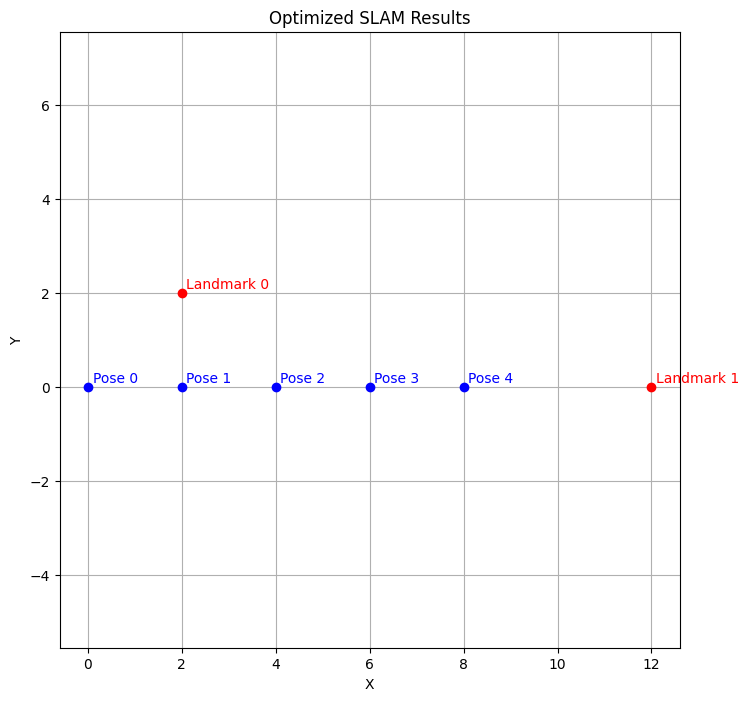

In [ ]:
import matplotlib.pyplot as plt

def plot_results(poses, landmarks):
    plt.figure(figsize=(8, 8))

    # Plot poses
    for i, pose in poses.items():
        x, y = pose.x(), pose.y()
        plt.plot(x, y, 'bo')  # Blue circle for poses
        plt.text(x + 0.1, y + 0.1, f"Pose {i}", color="blue")

    # Plot landmarks
    for i, landmark in landmarks.items():
        x, y = landmark[0], landmark[1]  # Access numpy array directly
        plt.plot(x, y, 'ro')  # Red circle for landmarks
        plt.text(x + 0.1, y + 0.1, f"Landmark {i}", color="red")

    plt.xlabel("X")
    plt.ylabel("Y")
    plt.title("Optimized SLAM Results")
    plt.grid()
    plt.axis("equal")
    plt.show()

# Collect optimized poses and landmarks
optimized_poses = {i: result.atPose2(symbol('x', i)) for i in range(5)}
optimized_landmarks = {i: result.atPoint2(symbol('l', i)) for i in range(len(landmark_positions))}

plot_results(optimized_poses, optimized_landmarks)


Robust Noise Models

In [ ]:
robust_model = gtsam.noiseModel.Robust.Create(
    gtsam.noiseModel.mEstimator.Huber(1.0), gtsam.noiseModel.Diagonal.Sigmas([0.1, 0.1])
)

# Replace measurement noise with robust noise model
graph.replace(2, gtsam.GenericProjectionFactorCal3_S2(
    gtsam.Point2(2.0, 2.0), robust_model, symbol('x', 0), symbol('l', 0), gtsam.Cal3_S2()))


Incremental SLAM with ISAM2

In [ ]:
import gtsam
from gtsam.symbol_shorthand import X

# Create an empty graph
graph = gtsam.NonlinearFactorGraph()

# Create initial estimate
initial_estimate = gtsam.Values()

# Add a Pose2 prior to the graph
prior_mean = gtsam.Pose2(0, 0, 0)  # (x, y, theta)
prior_noise = gtsam.noiseModel.Diagonal.Sigmas([0.1, 0.1, 0.1])
graph.add(gtsam.PriorFactorPose2(X(0), prior_mean, prior_noise))

# Add initial estimate
initial_estimate.insert(X(0), gtsam.Pose2(0, 0, 0))

# Create ISAM2 instance
isam = gtsam.ISAM2()

# Update ISAM2 with graph and estimate
isam.update(graph, initial_estimate)

# Calculate the estimate
incremental_result = isam.calculateEstimate()

# Print results
print("Incremental results:")
for i in range(1):
    print(f"Pose {i}:", incremental_result.atPose2(X(i)))


Incremental results:
Pose 0: (0, 0, 0)

